In [16]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp

from icecream import ic

from msfm.utils import tfrecords, survey
from msfm.utils.input_output import read_yaml

In [17]:
def dset_remove_mean(kg_perts, sn, index, weight=1):
    # take the mean over the axis of size n_pix, weight has the dimension of the last axis (tomo) and is broadcast
    kg_perts -= tf.reduce_mean(kg_perts, axis=1, keepdims=True)*weight
    sn -= tf.reduce_mean(sn, axis=0, keepdims=True)*weight

    return kg_perts, sn, index

# TODO
def dset_add_biases(example):
    pass

# TODO make this compatible with multi node training
def get_train_dset(
    conf,
    repo_dir,
    tfr_pattern,
    pert_labels,
    i_noise,
    batch_size,
    is_eval=False,
    eval_seed=32,
    file_name_shuffle_buffer=128,
    file_name_shuffle_seed=17,
    examples_shuffle_buffer=128,
    examples_shuffle_seed=67,
    n_readers=8, # parallel readers, i.e. samples read out from different input files concurrently
    n_prefetch=3
):
    # load the pixel file to calculate the non padded mean
    data_vec_pix, _, _, tomo_patches_pix, _ = survey.load_pixel_file(conf, repo_dir)
    data_vec_len = len(data_vec_pix)
    tomo_patch_len = [len(patches_pix) for patches_pix in tomo_patches_pix]
    mean_correction = data_vec_len/np.array(tomo_patch_len)

    if is_eval:
        tf.random.set_seed(eval_seed)

    # get the file names, shuffle and dataset them
    # TODO shard the dataset?
    dset = tf.data.Dataset.list_files(tfr_pattern, shuffle=False)
    if not is_eval:
        dset = dset.repeat()
        dset = dset.shuffle(file_name_shuffle_buffer, seed=file_name_shuffle_seed)

    # interleave
    if is_eval:
        dset = dset.interleave(tf.data.TFRecordDataset, cycle_length=n_readers, block_length=1)
    else:
        dset = dset.interleave(tf.data.TFRecordDataset, cycle_length=n_readers, block_length=1,
                                             num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    # decode the dset, shapes kg_perts = (n_perts, n_pix, n_z_bins) and sn = (n_pix, n_z_bins)
    dset_parse_inverse = lambda example: tfrecords.parse_inverse_fiducial(example, pert_labels, i_noise)
    dset = dset.map(dset_parse_inverse, num_parallel_calls=tf.data.AUTOTUNE)

    # shuffle and batch
    if not is_eval:
        dset = dset.shuffle(examples_shuffle_buffer, seed=examples_shuffle_seed)
    dset = dset.batch(batch_size)

    # remove the mean
    dset = dset.map(lambda kg_perts, sn, index: dset_remove_mean(kg_perts, sn, index, mean_correction))

    # TODO add biases

    # add the noise, expand along the dimension of the perturbations
    add_noise = lambda kg_perts, sn, index: (kg_perts + tf.expand_dims(sn, axis=1), index)
    dset = dset.map(add_noise)

    dset = dset.prefetch(n_prefetch)

    return dset


In [18]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

repo_dir = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model"
tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v1/fiducial/DESy3_fiducial_???.tfrecord"
pert_labels = conf["analysis"]["fiducial"]["perturbations"]["labels"][:7]

ic(pert_labels)

ic| pert_labels: ['fiducial',
                  'delta_Aia_m',
                  'delta_Aia_p',
                  'delta_H0_m',
                  'delta_H0_p',
                  'delta_Ob_m',
                  'delta_Ob_p']


['fiducial',
 'delta_Aia_m',
 'delta_Aia_p',
 'delta_H0_m',
 'delta_H0_p',
 'delta_Ob_m',
 'delta_Ob_p']

In [52]:
type(conf)

dict

In [46]:
dset = get_train_dset(conf, repo_dir, tfr_pattern, pert_labels, 0, 5, examples_shuffle_buffer=3)

for x in dset.take(1):
    kg_perts, index = x

23-02-02 16:08:24    survey.py INF   Loaded pixel file 


In [47]:
pix_file = "../../data/DESY3_pixels_512.h5"
with h5py.File(pix_file, "r") as f:
    data_vec_pix = f["metacal/map_cut_outs/data_vec_ids"][:]
    non_tomo_patches_pix = f["metacal/masks/RING/non_tomo"][:]
    
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

In [48]:
kg_perts_np = kg_perts.numpy()
kg_perts_np.shape

(5, 7, 463872, 4)

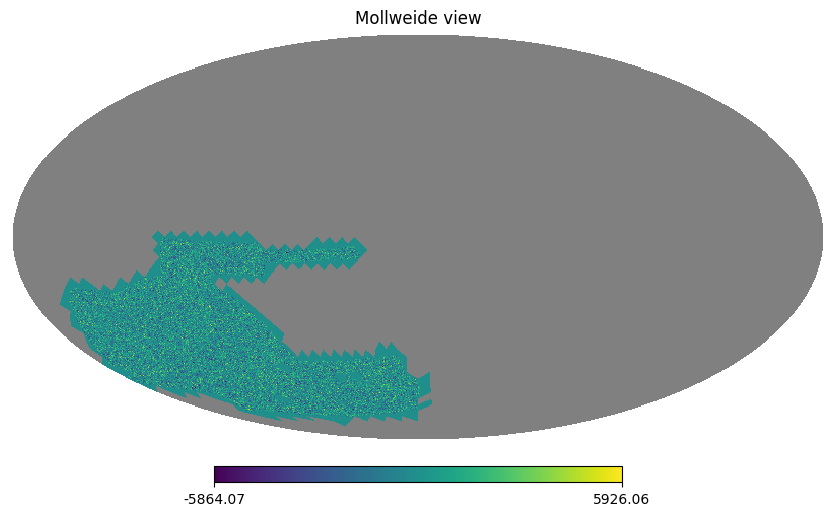

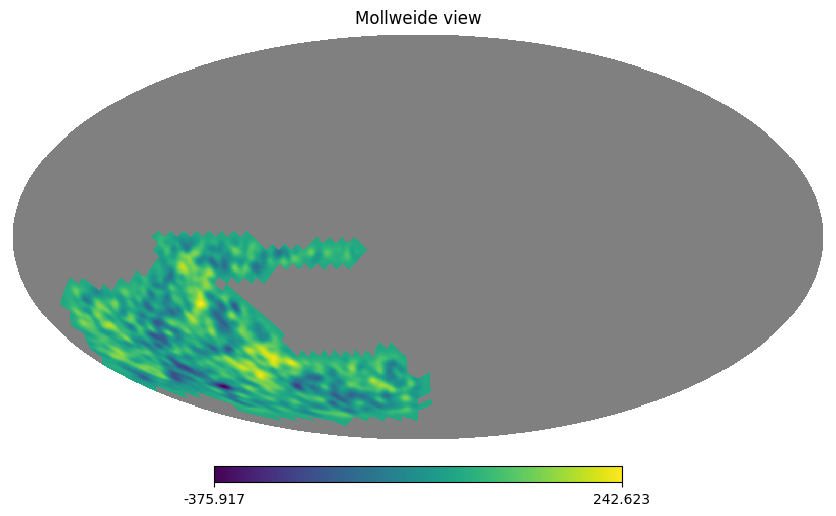

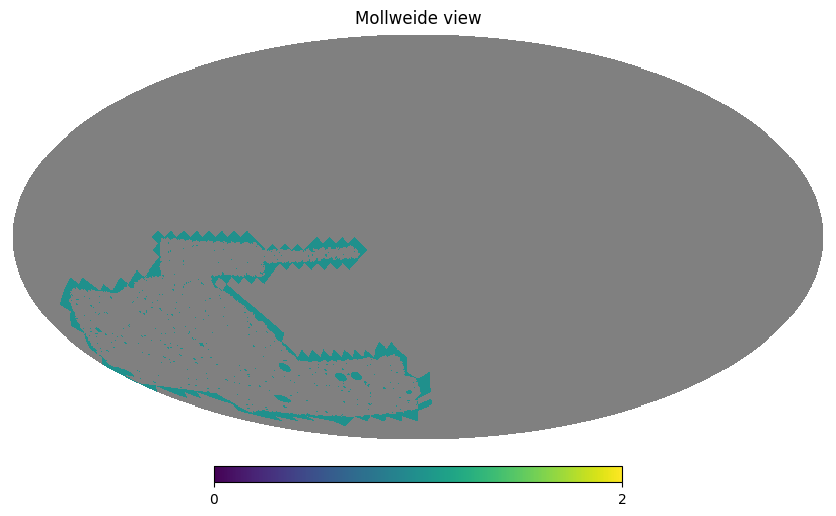

In [49]:
i_batch = 0
i_pert = 0
i_tomo = 0

hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[data_vec_pix] = kg_perts_np[i_batch, i_pert, :, i_tomo]

hp.mollview(hp_map, nest=True)

hp_map_ring = hp.pixelfunc.reorder(hp_map, inp="NESTED", out="RING")
hp_smoothed = hp.sphtfunc.smoothing(hp_map_ring, fwhm=0.05)
hp.mollview(hp_smoothed)

# hp_smoothed = hp.sphtfunc.smoothing(hp_map, fwhm=0.01, nest=True)
# hp.mollview(hp_smoothed, nest=True)

padding = np.full(n_pix, hp.UNSEEN)
padding[hp_map==0] = 1
hp.mollview(padding, nest=True)


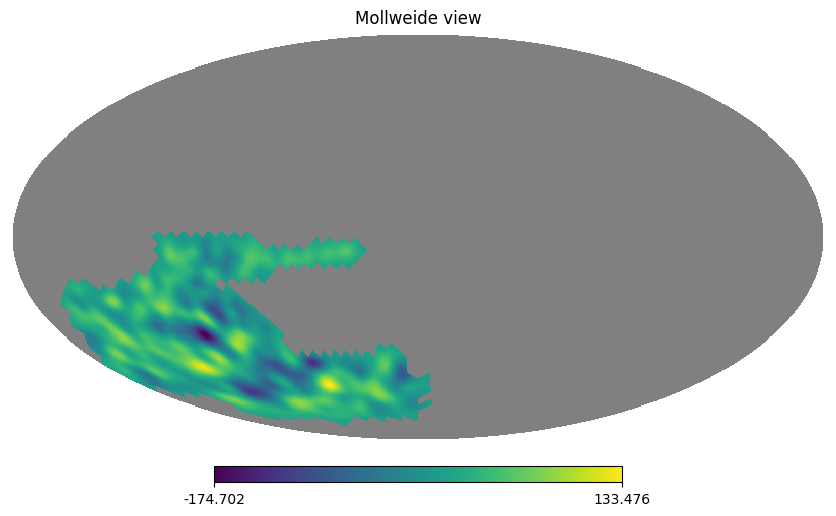

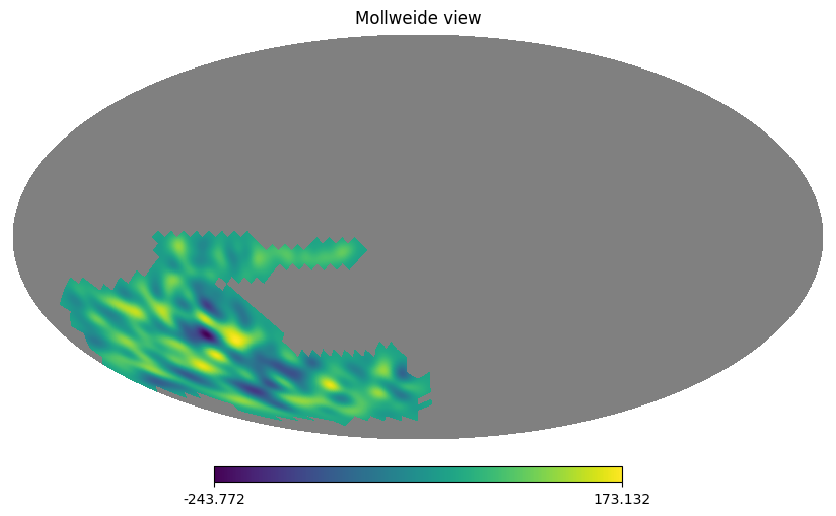

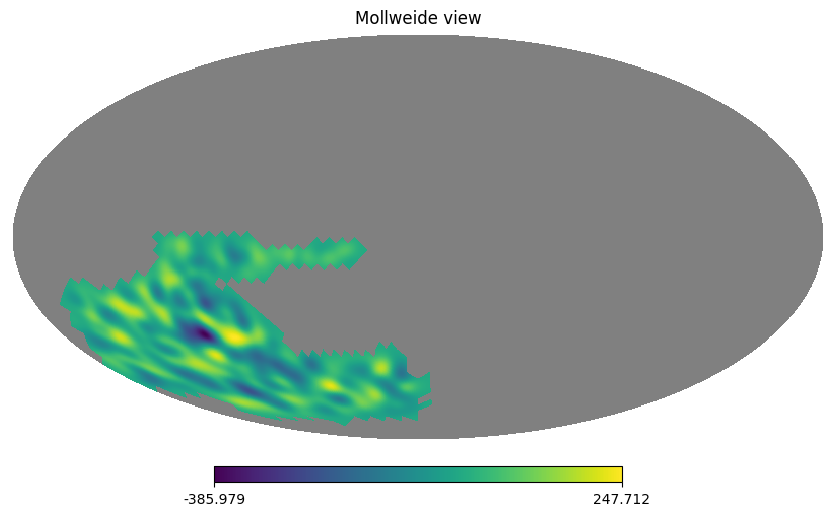

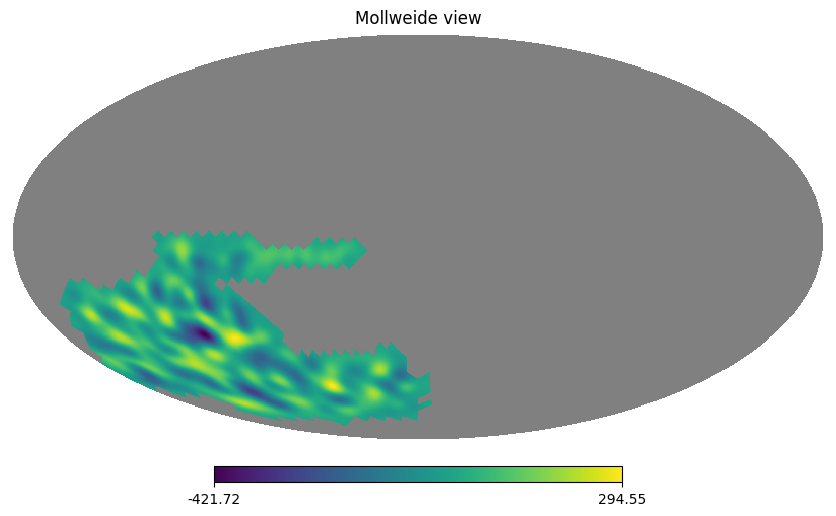

In [50]:
i_batch = 4
i_pert = 0

for i_tomo in range(4):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg_perts_np[i_batch, i_pert, :, i_tomo]

    # hp.mollview(hp_map, nest=True)

    hp_map_ring = hp.pixelfunc.reorder(hp_map, inp="NESTED", out="RING")
    hp_smoothed = hp.sphtfunc.smoothing(hp_map_ring, fwhm=0.1)
    hp.mollview(hp_smoothed)

    # hp_smoothed = hp.sphtfunc.smoothing(hp_map, fwhm=0.01, nest=True)
    # hp.mollview(hp_smoothed, nest=True)

    # padding = np.full(n_pix, hp.UNSEEN)
    # padding[hp_map==0] = 1
    # hp.mollview(padding, nest=True)
